# Creating Loneliness Index for GPs in Scotland using Prescription Data, 2022

- Outputs an index of loneliness scores for GPs' postcodes in Scotland for Jan 2022 - Dec 2022 
- To be used as an input to map area scores

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# Path to files
path = "../../extdata/"

# Read drug data

In [3]:
# Reads a csv that identifies loneliness related conditions and matches it to its associated medication
drug_data = pd.read_csv(path + "drug_list.csv")

# Process Prescribing Data
- Uses "Prescriptions in the Community" .csv files that come from: https://www.opendata.nhs.scot/dataset/prescriptions-in-the-community to identify loneliness related conditions based on prescriptions
- Prescription in the Community are monthly files containing community pharmacy activity and direct pharmaceutical care services  for all NHS health boards.
- Outputs a dataframe that multiplies loneliness related prescriptions by its count.

*Prescription in the Community csvs for each month in 2022 need to be saved in the prescriptions_scotland/ folder manually*

In [4]:
# column names
col_bnfname = "BNFItemDescription"
col_items = "NumberOfPaidItems"

In [5]:
# Function to find loneliness related conditions based on prescription
def code_loneliness(x):
    out = {}
    # coding by illness categories
    for illness in drug_data['illness'].unique():
        out[illness] = x[col_bnfname].str.contains("|".join(drug_data[drug_data['illness'] == illness]['medication']),
                                                 case=False, 
                                                 regex=True).fillna(False).astype('int16')
    # Make dataframe
    out = pd.DataFrame(out)
  
    # Return dataframe multiplied by counts of items
    return out.multiply(x[col_items], axis=0)

In [6]:
# Iterate over Prescription in the Community files, call code_loneliness() to count prescriptions 
# Outputs a df that is grouped by GP practice

monthly_data = []

for file in os.listdir(path + "prescriptions_scotland"):
    # Open prescribing files 
    prescribe = pd.read_csv(path + "prescriptions_scotland/" + file)
    prescribe.columns = prescribe.columns.str.strip()
    prescribe = prescribe[["GPPractice", col_bnfname, col_items]]
    print(f" Proccessing {file}")

    # Count prescriptions
    loneliness_prescribing = code_loneliness(prescribe[[col_bnfname, col_items]])
    prescribe = prescribe.merge(
        loneliness_prescribing, left_index=True, right_index=True
    )
    del loneliness_prescribing

    # Group by GPPractice and sum prescriptions across the year
    summary = prescribe.groupby("GPPractice", as_index=False).agg(sum)
    monthly_data.append(summary)
    print(f" Completed processing {file}")

 Proccessing pitc202201.csv
 Completed processing pitc202201.csv
 Proccessing pitc202202.csv
 Completed processing pitc202202.csv
 Proccessing pitc202203.csv
 Completed processing pitc202203.csv
 Proccessing pitc202204.csv
 Completed processing pitc202204.csv
 Proccessing pitc202205.csv
 Completed processing pitc202205.csv
 Proccessing pitc202206.csv
 Completed processing pitc202206.csv
 Proccessing pitc202207.csv
 Completed processing pitc202207.csv
 Proccessing pitc202208.csv
 Completed processing pitc202208.csv
 Proccessing pitc202209.csv
 Completed processing pitc202209.csv
 Proccessing pitc202210.csv
 Completed processing pitc202210.csv
 Proccessing pitc202211.csv
 Completed processing pitc202211.csv
 Proccessing pitc202212.csv
 Completed processing pitc202212.csv


In [7]:
monthly_prescriptions = pd.concat(monthly_data, ignore_index = True)

In [8]:
monthly_prescriptions.head(2)

,GPPractice,BNFItemDescription,NumberOfPaidItems,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety
0,10002,MAALOX_ORAL SUSP 175MG/200MG/5MLGAVISCON_LIQ O...,9510,594,20,700,704,107,485,41,0,3
1,10017,MAALOX_ORAL SUSP 175MG/200MG/5MLGAVISCON INFAN...,8734,550,35,658,664,89,420,56,0,5


In [9]:
# Count duplicates
monthly_prescriptions.duplicated().value_counts()

False    13148
True         7
Name: count, dtype: int64

Only a very small number of duplicates

In [10]:
# Look at duplicates
monthly_prescriptions[monthly_prescriptions.duplicated()]

,GPPractice,BNFItemDescription,NumberOfPaidItems,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety
2713,54636,PREDNISOLONE_TAB 5MG,1,0,0,0,0,0,0,0,0,0
7836,24931,TRIMETHOPRIM_TAB 200MG,1,0,0,0,0,0,0,0,0,0
10389,54636,AMOXICILLIN_CAP 500MGPREDNISOLONE_TAB 5MG,3,0,0,0,0,0,0,0,0,0
10920,90986,AMOROLFINE HCL_NAIL LACQUER KIT 5% 5ML,1,0,0,0,0,0,0,0,0,0
11795,71453,AMOXICILLIN_ORAL SUSP 250MG/5ML,1,0,0,0,0,0,0,0,0,0
12311,26049,FORCEVAL_CAP,1,0,0,0,0,0,0,0,0,0
13139,95020,GABAPENTIN_CAP 300MG,1,0,0,0,0,0,0,0,0,0


In [11]:
# Assume data entry error - drop duplicates as its a small number
monthly_prescriptions.drop_duplicates(inplace=True)

In [12]:
# Save aggregated data
monthly_prescriptions.to_csv(path + "monthly_prescriptions.csv")

# Join GPs to postcodes

- Use the 'GP Practice Contact Details and List Sizes' data from: https://www.opendata.nhs.scot/dataset/gp-practice-contact-details-and-list-sizes to get GP surgery codes and postcode
- Note that Scotland only publishes this four times a year (in Jan, Apr, Jul and Oct).

*GP Practice Contact Details and List Sizes csvs for each quarter in 2022 need to be saved in the processed_data/ folder manually*

In [13]:
monthly_prescriptions = pd.read_csv(path + "monthly_prescriptions.csv", index_col = 0)

In [14]:
# Get GP files
gp_path = path + "gp_data/"

In [15]:
gp_combine = []

for file in os.listdir(gp_path):
    gp_data = pd.read_csv(gp_path + file)
    gp_data = gp_data.rename(columns = {'PracticeCode': 'GPPractice'})
    gp_combine.append(gp_data[['GPPractice','Postcode']])
    print(file)

practice_contactdetails_apr2022-open-data.csv
practice_contactdetails_jan2022.csv
practice_contactdetails_jul2022-open-data.csv
practice_contactdetails_oct2022-open-data.csv


In [16]:
gp_postcodes = pd.concat(gp_combine, ignore_index = True)

In [17]:
gp_postcodes.head(2)

,GPPractice,Postcode
0,10002,DD2 5NH
1,10017,PH7 3SA


In [18]:
# Drop duplicates as contact details will be repeated across quarters
print(gp_postcodes.shape)
gp_postcodes.drop_duplicates(inplace = True)
print(gp_postcodes.shape)

(3663, 2)
(945, 2)


In [19]:
# Check number of GP Practices with multiple postcodes 
(gp_postcodes.groupby('GPPractice').count()).sort_values("Postcode", ascending = False).head(13)

,Postcode
GPPractice,
21505,2
40703,2
71379,2
71171,2
40224,2
40262,2
62986,2
70470,2
40046,2


Note that 12 GP practices have two postcodes assigned to them. Possible reasons for this are:

* Practices move to a new location.
* Practices are assigned a new postcode but don't physically move.
* Practice postcodes are wrongly entered at a particular wave and subsequently fixed.

If we were being very thorough we would align the quarter the gp reference details were released with the month of the prescription in the community files. Given it is a small number of GPs and only two postcodes each, we will take the first value in the df.


In [20]:
# Subset GP practices
gp_ids = gp_postcodes['GPPractice'].unique()
monthly_prescriptions = monthly_prescriptions[monthly_prescriptions['GPPractice'].isin(gp_ids)].copy()
monthly_prescriptions.shape

(11121, 12)

Above we are subsetting the monthly prescription data with GP Practices that appear in the GP Practice contact details table.  
The assumption is that the prescription in the community data includes non GP Practices e.g. pharmacies

In [21]:
# Join gp postcodes to prescription data
monthly_prescriptions_postcodes = monthly_prescriptions.merge(gp_postcodes, how = 'left', on = 'GPPractice')

In [2]:
monthly_prescriptions_postcodes.head(2)

NameError: name 'monthly_prescriptions_postcodes' is not defined

In [1]:
print(monthly_prescriptions_postcodes.shape)

NameError: name 'monthly_prescriptions_postcodes' is not defined

In [24]:
# Sum values by postcode to get total prescriptions across the year
monthly_prescriptions_postcodes['pcstrip'] = monthly_prescriptions_postcodes['Postcode'].str.replace("\s","")
monthly_prescriptions_postcodes = monthly_prescriptions_postcodes.groupby(["pcstrip"], as_index=False).sum()

In [25]:
print(monthly_prescriptions_postcodes.shape)

(739, 14)


In [26]:
# Get codes for GPPractices with >1 postcode
monthly_prescriptions_postcodes.groupby('GPPractice')['pcstrip'].count().sort_values(ascending=False)

GPPractice
258060     2
2910096    2
63783      1
847104     1
847896     1
          ..
480144     1
480324     1
480612     1
480780     1
5103672    1
Name: pcstrip, Length: 737, dtype: int64

- There are 2 practices codes which have 2 postcode assigned to them, this is about 1.3% of unique practices.
- These will be the same ones that have carried over from the GP contact details above.
- Drop the second instance of both as it is only a small number

In [27]:
# Drop second instance of these specific GPs
monthly_prescriptions_postcodes = monthly_prescriptions_postcodes[~monthly_prescriptions_postcodes.duplicated(subset='GPPractice', keep='first') | ~monthly_prescriptions_postcodes['GPPractice'].isin([2910096, 258060])]

In [28]:
# Expect length to decrease by 2
737 == len(monthly_prescriptions_postcodes)

True

In [29]:
# Save aggregated data
monthly_prescriptions_postcodes.to_csv(path + "monthly_prescriptions_postcodes.csv")

# Generate Statistics from Prescribing Counts

- Compute percentages per condition as total of all drugs prescribed per postcode
- Compute z-score per condition across postcodes
- Add z-scores of all conditions together to compute a loneliness score per postcode
- The loneliness variable is an equally weighted index of the conditions.


In [30]:
monthly_prescriptions_postcodes = pd.read_csv(path + "monthly_prescriptions_postcodes.csv", index_col=0)

In [31]:
monthly_prescriptions_postcodes = monthly_prescriptions_postcodes.drop(columns = ['Postcode','GPPractice', 'BNFItemDescription'])
monthly_prescriptions_postcodes.head(2)

,pcstrip,NumberOfPaidItems,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety
0,AB10 1NW,123460,9241,213,7959,8085,1287,5006,714,108,150
1,AB10 1QB,125712,8686,229,10289,10409,1427,6904,828,291,794


In [32]:
# Generate percentages for discrete illness groups out of total drugs prescribed

perc_cols = drug_data['illness'].unique()
target_cols = perc_cols + '_perc'

monthly_prescriptions_postcodes[target_cols] = monthly_prescriptions_postcodes[perc_cols].divide(monthly_prescriptions_postcodes[col_items], axis=0) * 100


In [33]:
monthly_prescriptions_perc = monthly_prescriptions_postcodes

In [34]:
monthly_prescriptions_perc.head(2)

,pcstrip,NumberOfPaidItems,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,depression_perc,alzheimers_perc,blood pressure_perc,hypertension_perc,diabeties_perc,cardiovascular disease_perc,insomnia_perc,addiction_perc,social anxiety_perc
0,AB10 1NW,123460,9241,213,7959,8085,1287,5006,714,108,150,7.485015,0.172526,6.446622,6.548680,1.042443,4.054755,0.578325,0.087478,0.121497
1,AB10 1QB,125712,8686,229,10289,10409,1427,6904,828,291,794,6.909444,0.182162,8.184581,8.280037,1.135134,5.491918,0.658648,0.231481,0.631602


## Standardisation

In [35]:
# Calculate the z scores per illness across postcodes

per_cols = ['depression_perc', 'alzheimers_perc', 'blood pressure_perc', 'hypertension_perc', 
            'diabeties_perc', 'cardiovascular disease_perc', 'insomnia_perc', 'addiction_perc',
            'social anxiety_perc']

for i, col in enumerate(per_cols):
    col_zscore = col[:-5] + 'zscore'  # Create new columns for z-scores
    monthly_prescriptions_perc[col_zscore] = stats.zscore(monthly_prescriptions_perc[col])


In [36]:
# Add conditions z scores for overall loneliness z score
monthly_prescriptions_perc['loneliness_zscore'] = monthly_prescriptions_perc[[ 'depressionzscore', 'alzheimerszscore',
       'blood pressurezscore', 'hypertensionzscore', 'diabetieszscore',
       'cardiovascular diseasezscore', 'insomniazscore', 'addictionzscore',
       'social anxietyzscore']].sum(axis=1)

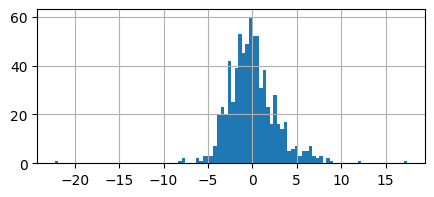

In [37]:
monthly_prescriptions_perc.loneliness_zscore.hist(bins=100, figsize = (5,2));

In [38]:
monthly_prescriptions_perc.rename(columns={'pcstrip':'postcode'}, inplace = True)

In [39]:
loneliness_postcode = monthly_prescriptions_perc[['postcode','loneliness_zscore']]

In [40]:
loneliness_postcode

,postcode,loneliness_zscore
0,AB10 1NW,-1.981616
1,AB10 1QB,7.773465
2,AB10 1UT,2.902790
3,AB10 1YE,1.194617
4,AB10 7QQ,-1.610345
...,...,...
734,ZE2 9DY,5.628561
735,ZE2 9HX,3.832447
736,ZE2 9NA,6.555395
737,ZE2 9QJ,8.470471


In [41]:
# Save aggregated data
loneliness_postcode.to_csv(path + "scotland_gp_2022.csv", index = False)